# Sensitivity analysis of benchmark results

sensitivity to:

* input data ($P_{load}$ and $P_{sun}$): variability, length
* PV panel sizing $P_{pv}^p$ (kWp)
* Storage capacity $E_{rated}$ (kWh)

Pierre Haessig, April 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Load testcase data

In [2]:
E_rated = 10 # kWh
P_pvp = 3 # kW

In [3]:
df = pd.read_csv('../data/data_2011-2012.csv', index_col=0, parse_dates=True)

# slice test weeks
df = df['2011-11-29':'2011-12-28'] # 30 test days

n = len(df)
n//48

30

In [4]:
P_load = df.GC
P_sun = df.GG/1.04*P_pvp;

dt = 0.5 # hours
t = np.arange(n)*dt # hours
td = t/24 #days

In [5]:
print('Data from {} to {} ({:.0f} days)'. format(df.index.date[0], df.index.date[-1], td[-1]))
print('* average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('* average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('* ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Data from 2011-11-29 to 2011-12-28 (30 days)
* average sun energy: 11.70 kWh/d
* average load      : 17.02 kWh/d
* ratio sun/load: 68.77%


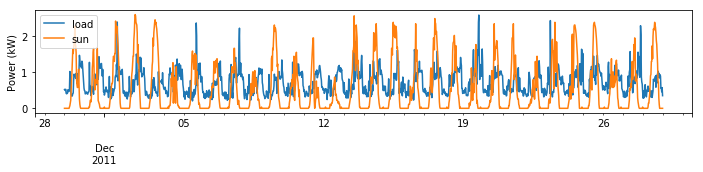

In [6]:
fig = plt.figure(figsize=(10,2.5))
P_load.plot(label='load')
P_sun.plot(label='sun')
plt.legend()
plt.ylabel('Power (kW)')
fig.tight_layout()

## Solar home simulation

using rule-based control, taken from [solar_home_rule-based-control.ipynb](../methods/python_rule-based/solar_home_rule-based-control.ipynb)

control strategy: battery should absorb absorb net production, as long as feasible:

$$P_{sto} = -P_{nl} = P_{sun} - P_{load}$$

In [7]:
def control(E_rated, P_load, P_sun, E_sto):
    P_nl = P_load - P_sun
    # outputs:
    P_sto = 0
    P_grid = 0
    P_curt = 0
    
    E_next = E_sto - P_nl*dt
    
    if P_nl>0: # (load > sun)
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0
        P_grid = P_nl + P_sto
    else:
        E_next = E_next if E_next<E_rated else E_rated
        P_sto = (E_next - E_sto)/dt # >0
        P_curt = -P_nl - P_sto
    return P_sto, P_grid, P_curt

In [8]:
def home_sim(E_rated, P_pvp, P_load, P_sun_1kW):
    '''simulate solar home with parameters `E_rated` and `P_pvp`
    and data `P_load`, `P_sun_1kW`
    '''
    n = len(P_load)
    P_sun = P_sun_1kW*P_pvp
    P_sto = np.zeros(n)
    E_sto = np.zeros(n+1)
    P_grid = np.zeros(n)
    P_curt = np.zeros(n)

    E_sto[0]= E_rated/2

    for k in range(n):
        P_sto[k], P_grid[k], P_curt[k] = control(E_rated, P_load[k], P_sun[k], E_sto[k])
        E_sto[k+1] = E_sto[k] + P_sto[k]*dt
        assert 0 <= E_sto[k+1] <= E_rated

    # extra outputs
    E_sto = E_sto[:-1]
    P_pv = P_sun - P_curt
    P_nl = P_load - P_sun
    
    # stats: cumulated energy in kWh/day
    stats = dict(
        E_load = P_load.mean()*24,
        E_sun  = P_sun.mean()*24,
        E_pv   = P_pv.mean()*24,
        E_curt = P_curt.mean()*24,
        E_grid = P_grid.mean()*24
    )
    # full output: out = pd.DataFrame()
    return stats

In [9]:
%time home_sim(E_rated, 3, P_load, P_sun/3)

CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 67.8 ms


{'E_curt': 0.0766615384615383,
 'E_grid': 5.438667948717948,
 'E_load': 17.01703333333333,
 'E_pv': 11.62641538461537,
 'E_sun': 11.70307692307691}

In [10]:
def pprint_stats(stats):
    'pretty print energy stats'
    s = '''E_load: {E_load:6.2f} kWh/d (data)
E_sun:  {E_sun:6.2f} kWh/d (data)
E_pv:   {E_pv:6.2f} kWh/d
E_curt: {E_curt:6.2f} kWh/d
E_grid: {E_grid:6.2f} kWh/d'''.format(**stats)
    print(s)

In [11]:
pprint_stats(home_sim(E_rated, 3, P_load, P_sun/3))

E_load:  17.02 kWh/d (data)
E_sun:   11.70 kWh/d (data)
E_pv:    11.63 kWh/d
E_curt:   0.08 kWh/d
E_grid:   5.44 kWh/d


## Parametric study

effect of storage size and PV size

In [12]:
nE = 41
E_rated_max = 20 # kWh
E_rated_list = np.linspace(0, E_rated_max, nE) 
dE = E_rated_list[1] - E_rated_list[0]
dE # step, kWh

0.5

In [13]:
nPV = 37
P_pv_max = 6 # kW_peak
P_pvp_list = np.linspace(0, P_pv_max, nPV) 
dP = P_pvp_list[1] - P_pvp_list[0]
dP # step, kW_peak

0.16666666666666666

In [14]:
print('nb of param values: {}. Simulation time: ~{:.1f} s'.format(nE*nPV, 50e-3*nE*nPV))

nb of param values: 1517. Simulation time: ~75.9 s


batch simulation... (40 ms/pt)

In [15]:
stats_list = []
for E_rated in E_rated_list:
    for P_pvp in P_pvp_list:
        stats = home_sim(E_rated, P_pvp, P_load, P_sun/3)
        stats['E_rated'] = E_rated
        stats['P_pvp'] = P_pvp
        stats_list.append(stats)

In [16]:
stats = pd.DataFrame(stats_list)
stats.head()

,E_curt,E_grid,E_load,E_pv,E_rated,E_sun,P_pvp
0,0.000000,17.017033,17.017033,0.000000,0.0,0.000000,0.000000
1,0.000000,16.366862,17.017033,0.650171,0.0,0.650171,0.166667
2,0.000000,15.716691,17.017033,1.300342,0.0,1.300342,0.333333
3,0.001363,15.067884,17.017033,1.949149,0.0,1.950513,0.500000
4,0.016341,14.432691,17.017033,2.584343,0.0,2.600684,0.666667


Folded output stats:

In [17]:
E_grid_rs = stats.E_grid.values.reshape((nE, nPV))
E_curt_rs = stats.E_curt.values.reshape((nE, nPV))
XP, YE = np.meshgrid(P_pvp_list, E_rated_list)

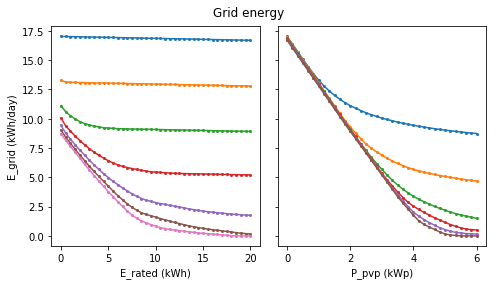

In [18]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(7,4))
ax[0].plot(E_rated_list, E_grid_rs[:,::6], 'o-', ms=2)
ax[1].plot(P_pvp_list, E_grid_rs[::8,:].T, 'o-', ms=2)

ax[0].set(xlabel='E_rated (kWh)', ylabel='E_grid (kWh/day)')
ax[1].set(xlabel='P_pvp (kWp)')
fig.suptitle('Grid energy')
fig.tight_layout(rect=(0, 0, 1, 0.96))

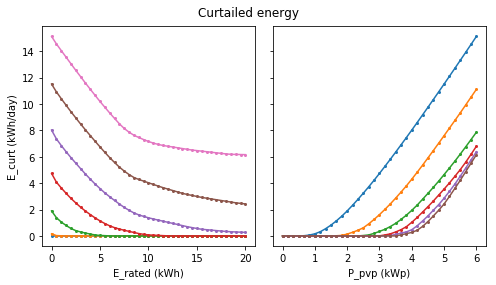

In [19]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(7,4))
ax[0].plot(E_rated_list, E_curt_rs[:,::6], 'o-', ms=2)
ax[1].plot(P_pvp_list, E_curt_rs[::8,:].T, 'o-', ms=2)

ax[0].set(xlabel='E_rated (kWh)', ylabel='E_curt (kWh/day)')
ax[1].set(xlabel='P_pvp (kWp)')
fig.suptitle('Curtailed energy')
fig.tight_layout(rect=(0, 0, 1, 0.96))

## 2D plot

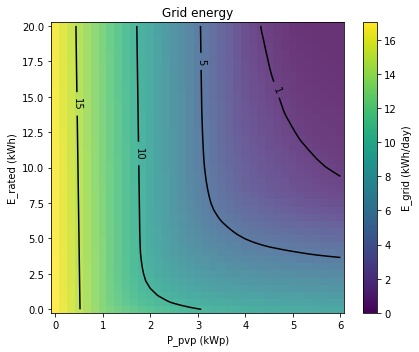

In [20]:
fig, ax = plt.subplots(figsize=(6,5))

imparams = dict(origin='lower',
                extent=[-dP/2, P_pv_max+dP/2, -dE/2, E_rated_max+dE/2],
                aspect='auto')
im = ax.imshow(E_grid_rs, **imparams, alpha=0.8)
#ax.plot(3, 10, 'rD', mec='k')
#ax.plot(4, 8, 'bD', mec='k')
CS = ax.contour(XP, YE, E_grid_rs, [1, 5, 10, 15], colors='k')
ax.clabel(CS, fmt='%.0f')
cbar = fig.colorbar(im)
cbar.set_label('E_grid (kWh/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188
ax.set(title='Grid energy', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout();

fig.savefig('Sizing_E_grid_heatmap.png', dpi=150)

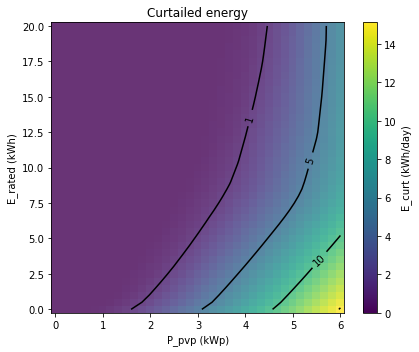

In [21]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(E_curt_rs, **imparams, alpha=0.8)
#ax.plot(3, 10, 'rD', mec='k')
#ax.plot(4, 8, 'bD', mec='k')
#ax.plot(3.5, 7, 'bD', mec='k')
CS = ax.contour(XP, YE, E_curt_rs, [1, 5, 10, 15], colors='k')
ax.clabel(CS, fmt='%.0f')
cbar = fig.colorbar(im)
cbar.set_label('E_curt (kWh/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188

ax.set(title='Curtailed energy', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout()

fig.savefig('Sizing_E_curt_heatmap.png', dpi=150)

### Cost analysis

simple linear cost function:

* 2 €/Wc (HT, pour 9 à 36 kWc, ISB http://www.photovoltaique.info/Couts-d-investissement.html)
* 0.5 €/kWh ([Tesla Powerwall](https://www.tesla.com/fr_FR/powerwall) 7 k€/13.5 kWh)

In [22]:
cP = 2 # k€/kWp
cE = 0.5 # k€/kWh
cost = XP*cP + YE*cE

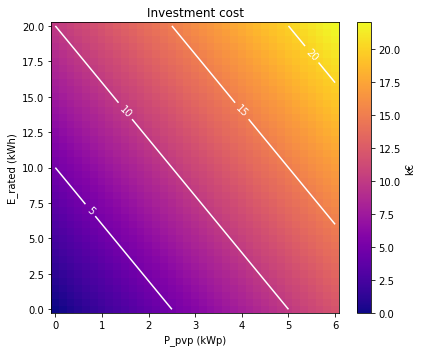

In [23]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(cost, **imparams, cmap='plasma', alpha=1)
#ax.plot(3, 10, 'bD', mec='k')
CS = ax.contour(XP, YE, cost, [5, 10, 15, 20], colors='w')
ax.clabel(CS, fmt='%.0f')
cbar = fig.colorbar(im)
cbar.set_label('k€')

ax.set(title='Investment cost', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout();

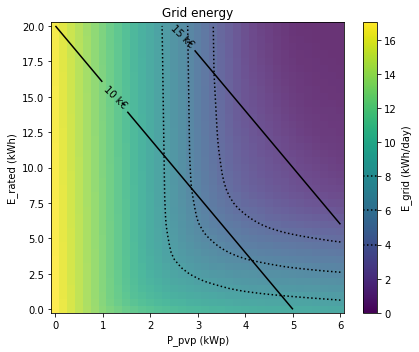

In [28]:
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(E_grid_rs, **imparams, alpha=0.8)
#ax.plot(3, 10, 'rD', mec='k')
#ax.plot(4, 8, 'bD', mec='k')
#ax.plot(3.5, 7, 'bD', mec='k')
CSE = ax.contour(XP, YE, E_grid_rs, [4, 6, 8], colors='k', linestyles=':')


CSc = ax.contour(XP, YE, cost, [10, 15], colors='k')
ax.clabel(CSc, fmt='%.0f k€')
cbar = fig.colorbar(im)
cbar.add_lines(CSE)
cbar.lines[0].set_linestyles(':')
cbar.set_label('E_grid (kWh/day)')
cbar.solids.set_edgecolor("face") # hack fix of overlap issue https://github.com/matplotlib/matplotlib/issues/1188

ax.set(title='Grid energy', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)')
fig.tight_layout()

fig.savefig('Sizing_E_grid_invest_heatmap.png', dpi=150)

#### Total cost

hyp: E_grid priced at 0.2 €/kWh on 20 years

In [36]:
c_grid = 0.20 # €/kWh on 20 years
cost_tot = cost+E_grid_rs*20*365.25*c_grid/1000

In [78]:
def total_cost_map(c_grid, save=False):
    fig, ax = plt.subplots(figsize=(6,5))
    
    cost_tot = cost+E_grid_rs*20*365.25*c_grid/1000
    im = ax.imshow(cost_tot, **imparams, cmap='plasma',
                   vmin=15, vmax=40) # fix v range for making series of plots
    #ax.plot(4, 8, 'D', mec='k', color=(0,1,0), label='bench sizing')
    CS = ax.contour(XP, YE, cost_tot, [16, 18, 20], colors='w')
    ax.clabel(CS, fmt='%.0f')
    cbar = fig.colorbar(im)
    cbar.add_lines(CS)
    cbar.set_label('k€')

    ax.set(
        title='Total cost\n on 20 yr, grid at {:.2f} €/kWh'.format(c_grid),
        xlabel='P_pvp (kWp)',
        ylabel='E_rated (kWh)'
    )
    fig.tight_layout();
    if save:
        fig.savefig('Total_cost_map_grid{:.2f}.png'.format(c_grid), dpi=150)

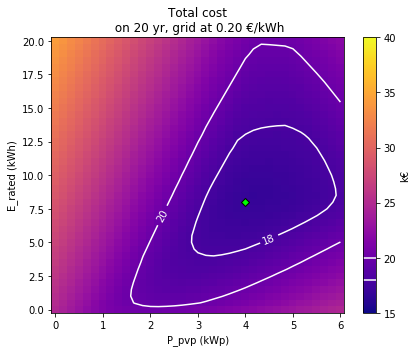

In [79]:
total_cost_map(0.20)

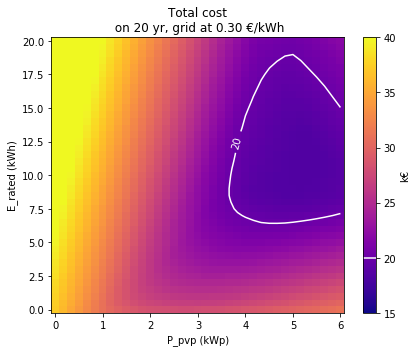

In [31]:
for cgrid in np.arange(15, 31)/100:
    plt.close()
    total_cost_map(cgrid, save=True)

#### 3D plot

In [32]:
from mpl_toolkits.mplot3d import Axes3D

In [33]:
%matplotlib inline

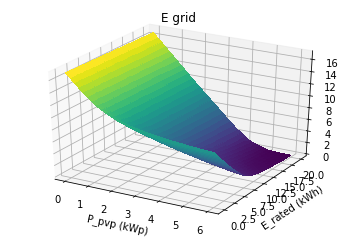

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(XP, YE, E_grid_rs, cmap='viridis', antialiased=False)
ax.set(title='E grid', xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)');

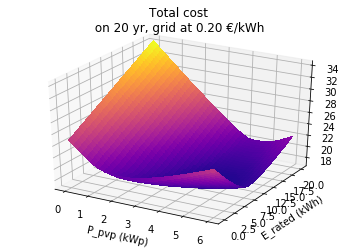

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(XP, YE, cost_tot, cmap='plasma', antialiased=False)
ax.set(
    title='Total cost\n on 20 yr, grid at {:.2f} €/kWh'.format(c_grid),
    xlabel='P_pvp (kWp)', ylabel='E_rated (kWh)');

## Uncertainty of the energy statistics

### Load input data bootstrap (P_sun, P_load)

load bootstrap data generated in [data_variability_bootstrap.ipynb](../data/data_variability_bootstrap.ipynb)

In [39]:
df_bs = pd.read_csv('../data/test-data_2011-11-29_30-days_bl-3_bs-400.csv', index_col=0, parse_dates=True)
df_bs.head(3)

,GC0,GG0,GC1,GG1,GC2,GG2,GC3,GG3,GC4,GG4,...,GC395,GG395,GC396,GG396,GC397,GG397,GC398,GG398,GC399,GG399
2011-11-29 00:00:00,0.468,0.0,0.436,0.0,0.310,0.0,0.386,0.0,0.482,0.0,...,0.580,0.0,0.428,0.0,0.510,0.0,0.338,0.0,0.482,0.0
2011-11-29 00:30:00,0.504,0.0,0.432,0.0,0.452,0.0,0.266,0.0,0.344,0.0,...,0.626,0.0,0.710,0.0,0.538,0.0,0.366,0.0,0.344,0.0
2011-11-29 01:00:00,0.394,0.0,0.488,0.0,0.252,0.0,0.284,0.0,0.376,0.0,...,0.578,0.0,0.402,0.0,0.448,0.0,0.568,0.0,0.376,0.0


In [40]:
nsamp = len(df_bs.columns)//2
nsamp

400

split load and sun, and scale sun properly

In [41]:
P_load_bs = df_bs.iloc[:,range(0,nsamp*2, 2)]
P_load_bs.columns = range(nsamp)
P_load_bs.head(3)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
2011-11-29 00:00:00,0.468,0.436,0.310,0.386,0.482,0.386,0.432,0.672,0.386,0.428,...,0.436,0.436,0.338,0.386,0.842,0.580,0.428,0.510,0.338,0.482
2011-11-29 00:30:00,0.504,0.432,0.452,0.266,0.344,0.266,0.316,0.560,0.266,0.710,...,0.432,0.432,0.366,0.266,0.416,0.626,0.710,0.538,0.366,0.344
2011-11-29 01:00:00,0.394,0.488,0.252,0.284,0.376,0.284,0.360,0.664,0.284,0.402,...,0.488,0.488,0.568,0.284,0.500,0.578,0.402,0.448,0.568,0.376


In [42]:
P_sun_1k_bs = df_bs.iloc[:,range(1,nsamp*2, 2)]/1.04
P_sun_1k_bs.columns = range(nsamp)
P_sun_1k_bs.head(3)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
2011-11-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-29 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-29 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


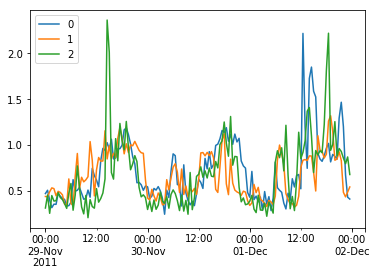

In [43]:
P_load_bs.iloc[:48*3,:3].plot();

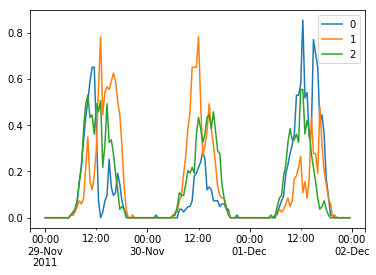

In [45]:
P_sun_1k_bs.iloc[:48*3,:3].plot();

Batch sim ~ 16 s

In [46]:
40e-3 * 400

16.0

In [69]:
E_rated = 8 # kWh
P_pvp = 4 # kWp

In [70]:
bs_stats = []
for i in range(nsamp):
    stats = home_sim(E_rated, P_pvp, P_load_bs[i], P_sun_1k_bs[i])
    bs_stats.append(stats)

In [71]:
bs_stats = pd.DataFrame(bs_stats)
bs_stats['E_nl'] = bs_stats.E_load - bs_stats.E_sun
bs_stats.head(2)

,E_curt,E_grid,E_load,E_pv,E_sun,E_nl
0,2.140149,3.861659,16.899933,13.007159,15.147308,1.752626
1,1.686764,3.244746,17.397167,14.099005,15.785769,1.611397


In [72]:
bs_stats.describe(percentiles=[0.025, 0.975])

,E_curt,E_grid,E_load,E_pv,E_sun,E_nl
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,1.930973,3.407228,17.033584,13.556331,15.487304,1.546280
std,0.536385,0.505198,0.327569,0.573920,0.961932,0.940237
min,0.477362,2.153490,16.178533,12.047226,12.793205,-0.972462
2.5%,0.893543,2.398383,16.426194,12.393988,13.441099,-0.200475
50%,1.894053,3.373963,17.028067,13.564173,15.544103,1.542191
97.5%,2.986444,4.432953,17.752513,14.699029,17.261795,3.391600
max,3.588233,4.880692,18.267800,14.907762,17.882564,4.140562


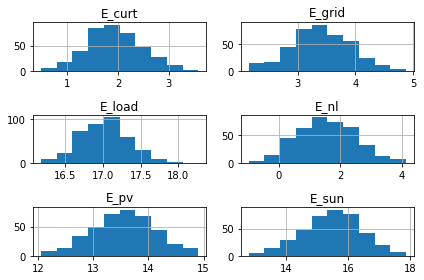

In [73]:
bs_stats.hist();
plt.tight_layout()

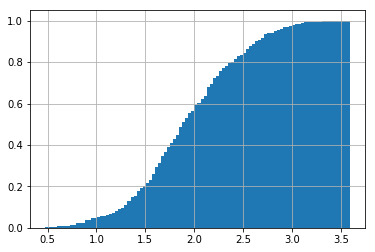

In [74]:
bs_stats.E_curt.hist(cumulative=True, bins=100, density=True);

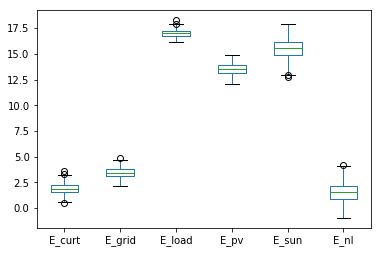

In [75]:
bs_stats.plot.box();

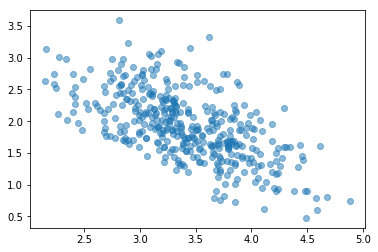

In [76]:
plt.plot(bs_stats.E_grid, bs_stats.E_curt, 'o', alpha=0.5);

In [56]:
from pandas.plotting import scatter_matrix

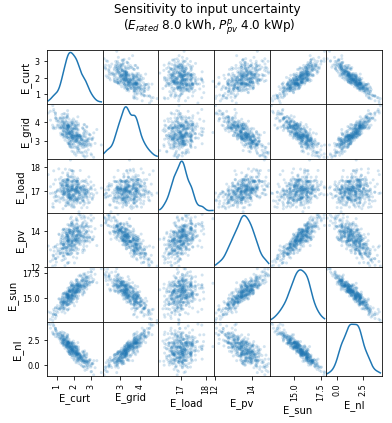

In [80]:
scatter_matrix(bs_stats, alpha=0.2, figsize=(6, 6), diagonal='kde')
title = 'Sensitivity to input uncertainty \n' +\
        '($E_{{rated}}$ {:.1f} kWh, $P_{{pv}}^p$ {:.1f} kWp)'.format(E_rated, P_pvp)
plt.suptitle(title);

fname = 'Input_uncertain_scat_E{:.0f}_P{:.0f}'.format(E_rated, P_pvp)
plt.savefig(fname + '.pdf')
plt.savefig(fname + '.png', dpi=150)

---

Plot trajectories. NOT YET DONE

## Sizing plots with input uncertainty

TODO: run solar home simulation:

* for each bootstrapped sample
* for each sizing param (E_rated, P_pvp)

to see how the sizing is affected.

Open questions:

* is the optimal ratio E/P changing (e.g. the position of the "knee" of the iso-P_grid lines)
* is the global size changing: bigger battery AND bigger panels?